In [1]:
import lsst.daf.butler as daf_butler
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from matplotlib.patches import Circle
from scipy.signal.signaltools import wiener
import scipy.stats
import matplotlib as mplot

import sys
sys.path.append('/home/z/zhzhuoqi/.local/lib/python3.11/site-packages/')

import cv2
import tree_ring_helper as helper
from scipy.ndimage.filters import gaussian_filter

# Generic bunch of imports (not all of these are needed)
import os
import numpy as np
import glob
from astropy.io import fits
import pandas as pd
import pickle as pkl
import galsim
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker
import tqdm
from scipy.optimize import minimize
from scipy import interpolate

/tmp/ipykernel_7469/758664152.py:6: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener
/tmp/ipykernel_7469/758664152.py:15: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


### Measuring tree-rings
The first part of this measures tree-rings from flat images. We first apply a high-pass filter and a Gaussian smoothing on the flat images (see `preprocess` below). Then we load the tree-ring centers from a `csv` file, which contained tree-rings centers for portion of the CCDs measured by HyeYun. We then compute the mean of the normalized flat by radial bins around the tree-ring centers. We also obtain error bars on the tree-ring profiles by bootstraping. (See `get_signal_bootstrap` below for how the tree-rings and errors are measured.)

In [2]:
def filter1d(A, smoothing=150, power=2.0):
    n = A.size
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    n = 2 * (n // 2)
    T = np.fft.rfft(A[:n])
    # Last axis (kx) uses rfft encoding.
    k = np.fft.rfftfreq(n)
    kpow = k ** power
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    S[:n] = np.fft.irfft(T * F)
    return S

In [3]:
def apply_filter(A, smoothing=100, power=1.0):
    ny, nx = A.shape
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    nx = 2 * (nx // 2)
    ny = 2 * (ny // 2)
    T = np.fft.rfft2(A[:ny, :nx])
    # Last axis (kx) uses rfft encoding.
    kx = np.fft.rfftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kpow = (kx ** 2 + ky[:, np.newaxis] ** 2) ** (power / 2.)
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    S[:ny, :nx] = np.fft.irfft2(T * F)
    return S

In [4]:
e2v_R = ['R11','R12','R13','R14','R21','R22','R23','R24','R30','R31','R32','R33','R34']
itl_R = ['R01','R02','R03','R10','R20','R41','R42','R43']

In [5]:
import csv
xy_0 = {}
vendor = {}

with open('tr_center_flatField_Volt0.csv','r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader) #skip the header in the first line
    for row in csvreader:
        xy_0[row[-1]] = [float(row[-6]),float(row[-5])]

In [6]:
def bootstrap(data, n=200):
    mean = np.mean(data)
    samples = np.zeros(n)

    for i in range(n):
        samples[i] = np.mean(np.random.choice(data, size=len(data), replace=True))
    var = np.var(samples)
    return mean, var

In [7]:
def get_high_im(filt, detector):
    
    repo = '/repo/ir2'
    acq_run = 13550
    weekly = 'w_2023_41'

    collections = [f'u/lsstccs/eo_raft_lambda_mosaics_{acq_run}_{weekly}']
    butler = daf_butler.Butler(repo, collections=collections)
    flats = butler.registry.queryDatasets('postISRCCD', instrument="LSSTCam", where = (f"exposure.science_program='{acq_run}' AND exposure.observation_reason='lambda' AND physical_filter='ef_43~{filt}' AND detector={detector}"))
    refs = list(flats)
    
    flat = butler.get('postISRCCD',dataId = refs[0].dataId, collections=collections)
    flat = flat.image.array
    var = flat.copy()
    var /= np.mean(var**2)
    flat /= np.mean(flat)
    flat -= 1
    
    camera = butler.get('camera',collections=collections,instrument='LSSTCam')
    detectors = []
    for _ in camera: 
        detectors.append(_)
        
        
    return flat, var, xy_0[detectors[detector].getName()]

In [8]:
def get_low_im(filt, detector):
        
    repo = '/repo/ir2'
    acq_run = 13491
    weekly = 'w_2023_41'
    
    collections = [f'u/lsstccs/eo_raft_lambda_mosaics_{acq_run}_{weekly}']
    butler = daf_butler.Butler(repo, collections=collections)
    flats = butler.registry.queryDatasets('postISRCCD', instrument="LSSTCam", where = (f"exposure.science_program='{acq_run}' AND exposure.observation_reason='lambda' AND physical_filter='{filt}' AND detector={detector}"))
    refs = list(flats)
    
    flat = butler.get('postISRCCD',dataId = refs[0].dataId, collections=collections)
    flat = flat.image.array
    var = flat.copy()
    var /= np.mean(var**2)
    flat /= np.mean(flat)
    flat -= 1
    
    camera = butler.get('camera',collections=collections,instrument='LSSTCam')
    detectors = []
    for _ in camera: 
        detectors.append(_)
        
        
    return flat, var, xy_0[detectors[detector].getName()]

In [9]:
def preprocess(flat, high_pass=True, Gaussian=True):
    if high_pass: 
        flat = apply_filter(flat, 100, power=2.0)
    if Gaussian: 
        flat = gaussian_filter(flat, 8.)
    return flat

In [10]:
def get_signal_bootstrap(flatim, center, mask0, r_range=(1000,5000)): 
    maxR = 7000
    xc, yc = center

    polar_img = cv2.warpPolar(flatim*mask0, (int(maxR), 3600), (xc,yc), maxR, cv2.WARP_POLAR_LINEAR)
    polar_msk = cv2.warpPolar(np.ones_like(flatim*mask0), (int(maxR), 3600), (xc,yc), maxR, cv2.WARP_POLAR_LINEAR)
    polar_msk[polar_msk==0] = np.nan

    binwidth = 8
    rmax = 6000
    freq = 360

    signal = np.zeros(np.shape(polar_img)[1]//binwidth)
    signal_var = np.zeros(np.shape(polar_img)[1]//binwidth)

    polarflat = (polar_img*polar_msk).T
    for i in range(len(signal)): 
        pixval = polarflat[i*binwidth:(i+1)*binwidth].flatten()
        pixval = pixval[~np.isnan(pixval)]
        if len(pixval)>0: 
            signal[i], signal_var[i] = bootstrap(pixval)
        else: 
            signal[i] = np.nan
            signal_var[i] = np.nan

    rsignal = np.arange(np.size(signal))*binwidth + binwidth/2.

    signal_mask = (~np.isnan(signal))*(rsignal<rmax)*(rsignal>=r_range[0])*(rsignal<=r_range[1])
    signal = signal[signal_mask]
    signal = signal-np.nanmean(signal)
    signal_var = signal_var[signal_mask]
    rsignal = rsignal[signal_mask]
    
    return rsignal, signal, signal_var

In [11]:
filts = ['uv','blue','red','nm750','nm850','nm960']

In [12]:
repo = '/repo/ir2'
acq_run = 13550
weekly = 'w_2023_41'

collections = [f'u/lsstccs/eo_raft_lambda_mosaics_{acq_run}_{weekly}']
butler = daf_butler.Butler(repo, collections=collections)
camera = butler.get('camera',collections=collections,instrument='LSSTCam')
detectors = []

for _ in camera: 
    detectors.append(_)

In [13]:
# # compute tree-rings from all detectors (takes ~ 7 hrs to run)
collections = [f'u/lsstccs/eo_raft_lambda_mosaics_{acq_run}_{weekly}']
camera = butler.get('camera',collections=collections,instrument='LSSTCam')
detectors = []
for _ in camera: 
    detectors.append(_)

for detector in tqdm.tqdm(detectors):
    for filt in filts:
        try: 
            flat, var, center = get_low_im(filt, detector.getId())
            flat_sm = preprocess(flat)
            mask0 = (flat_sm<0.01)*(flat_sm>-0.01).astype(np.float64)
            mask0[mask0==0] = np.nan
            rsignal, signal, signal_var = get_signal_bootstrap(flat_sm, center, mask0)
            # np.save(f'dats/TR_{detector}_{filt}_low',np.array([rsignal, signal, signal_var]))
            
            flat, var, center = get_high_im(filt, detector.getId())
            flat_sm = preprocess(flat)
            mask0 = (flat_sm<0.01)*(flat_sm>-0.01).astype(np.float64)
            mask0[mask0==0] = np.nan
            rsignal, signal, signal_var = get_signal_bootstrap(flat_sm, center, mask0)
            # np.save(f'dats/TR_{detector}_{filt}_high',np.array([rsignal, signal, signal_var]))
        except: 
            continue

### Statistics on tree-rings

In [14]:
from scipy.optimize import least_squares
def linear(params, x): 
    return params[0]*x+params[1]

def residual(params, x, y, err_x, err_y): 
    y_pred = linear(params, x)
    return (y-y_pred)/np.sqrt(err_y**2+params[0]**2*err_x**2)

In [15]:
def show_TR(detector): 
    cmap = mplot.colormaps['inferno']
    for i,filt in enumerate(filts): 
        rsignal, signal, err = np.load(f'dats/TR_{detector}_{filt}_high.npy')
        err = np.sqrt(err)
        color = cmap(1/8.+i/8.)
        #if i%3==1:
        plt.plot(rsignal, signal, label=f'df/f, {filt}', color=color)
    plt.xlim(1000,5000)
    plt.ylim(-0.001, 0.001)
    
    for i,filt in enumerate(filts): 
        rsignal, signal, err = np.load(f'dats/TR_{detector}_{filt}_low.npy')
        err = np.sqrt(err)
        color = cmap(1/8.+i/8.)
        #if i%3==1: 
        #plt.plot(rsignal, signal, color=color,alpha=0.4)
    
    plt.legend()
    plt.xlabel('radius from tree ring center (pix)')
    plt.ylabel('df/f')
    
    rmask = (rsignal>1000)*(rsignal<5000)
    # plt.title(f'detector {detector}, high vs. low volt')
    plt.title(f'detector {detector}, wavelength dependence')
    plt.axhline(0, ls='--', color='grey')
    plt.show()
    pass

In [16]:
def show_fit(detector): 
    nrow, ncol = 3,2
    fig, axes = plt.subplots(nrow, ncol)#, sharex=True, sharey=True)

    cmap = mplot.colormaps['inferno']
    for i, filt in enumerate(filts):
        color = cmap(1/8.+i/8.)
    
        rsignal_low, signal_low, signal_var_low = np.load(f'dats/TR_{detector}_{filt}_low.npy')
        rsignal_high, signal_high, signal_var_high = np.load(f'dats/TR_{detector}_{filt}_high.npy')
        rsignal, ind_low, ind_high = np.intersect1d(rsignal_low, rsignal_high, return_indices=True)
        TR_low, err_high = signal_low[ind_low], np.sqrt(signal_var_low[ind_low])
        TR_high, err_low = signal_high[ind_high], np.sqrt(signal_var_high[ind_high])
        # TR_low = filter1d(TR_low)
        # TR_high = filter1d(TR_high)
        
        result = least_squares(residual, [1,0], args=(TR_low, TR_high, err_low, err_high))
        k, b = result['x']
        cov = np.linalg.inv(result['jac'].T.dot(result['jac']))
        k_err, b_err = np.sqrt(np.diag(cov))
        
        row, col = i//ncol, i%ncol
        ax = axes[row][col]
        ax.errorbar(TR_low, TR_high, xerr=err_low, yerr=err_high, color=color, ls='none', marker='o')
        ax.set_xlim(1.1*np.min(TR_low),1.1*np.max(TR_low))
        ax.set_ylim(1.1*np.min(TR_high),1.1*np.max(TR_high))
        ax.set_title(f'{filt}, k={np.round(k,2)}'+r'$\pm$'+f'{np.round(k_err,3)}')
        xx = np.linspace(-4e-3,4e-3,5)
        yy = k*xx+b
        ax.plot(xx,yy,color='red',ls='--',label=f'y={np.round(k,2)}*x+{np.round(b,6)}',zorder=10)
        ax.legend(loc='lower right')

        if col==0: 
            ax.set_ylabel('df/f high volt')
        if row==nrow-1: 
            ax.set_xlabel('df/f low volt')
    plt.suptitle(f'detector={detector}')
    plt.tight_layout()
    plt.show()
    pass

In [17]:
def low_vs_high(detector, filt):
    rsignal_low, signal_low, signal_var_low = np.load(f'dats/TR_{detector}_{filt}_low.npy')
    rsignal_high, signal_high, signal_var_high = np.load(f'dats/TR_{detector}_{filt}_high.npy')
    rsignal, ind_low, ind_high = np.intersect1d(rsignal_low, rsignal_high, return_indices=True)
    TR_low, err_high = signal_low[ind_low], np.sqrt(signal_var_low[ind_low])
    TR_high, err_low = signal_high[ind_high], np.sqrt(signal_var_high[ind_high])

    result = least_squares(residual, [1,0], args=(TR_low, TR_high, err_low, err_high))
    k, b = result['x']
    cov = np.linalg.inv(result['jac'].T.dot(result['jac']))
    k_err, b_err = np.sqrt(np.diag(cov))

    xx = np.linspace(-4e-3,4e-3,5)
    yy = k*xx+b
    cmap = mplot.colormaps['inferno']
    plt.plot(xx,yy,color='red',ls='--',label=f'y={np.round(k,2)}*x+{np.round(b,6)}',zorder=10)
    plt.errorbar(TR_low, TR_high, xerr=err_low, yerr=err_high, ls='none', marker='o')
    plt.xlim(1.1*np.min(TR_low),1.1*np.max(TR_low))
    plt.ylim(1.1*np.min(TR_high),1.1*np.max(TR_high))
    plt.title(f'{detector}, {filt}')
    plt.show()
    pass

In the following three plots, we show that (i) color dependence of tree-rings in a high-voltage flat image from an E2V sensor. (ii) the comparison of low and high voltage tree-rings of a single detector across all filters, and we fitted for the ratio between the tree-ring amplitudes. (iii) a zoomed-in version of (ii) on a single filter.

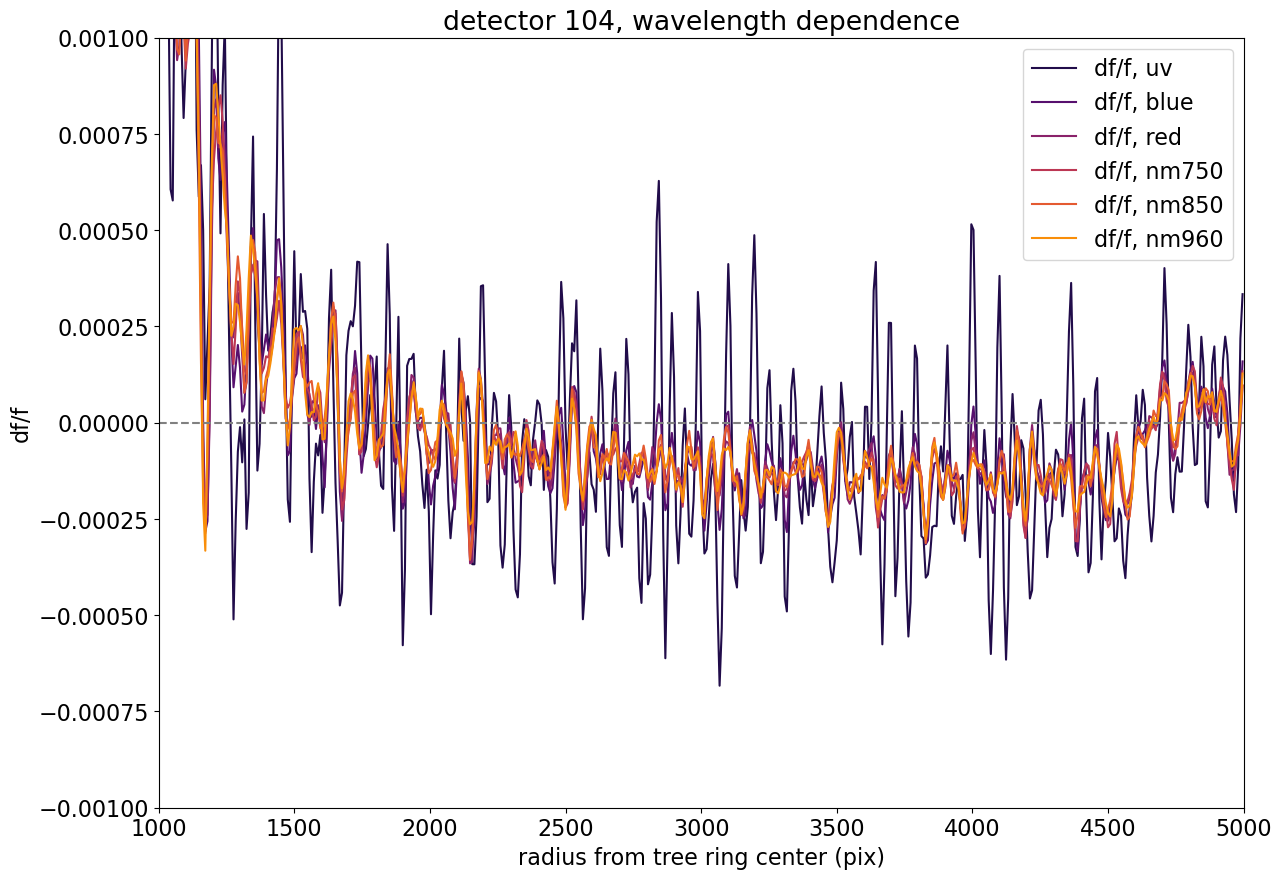

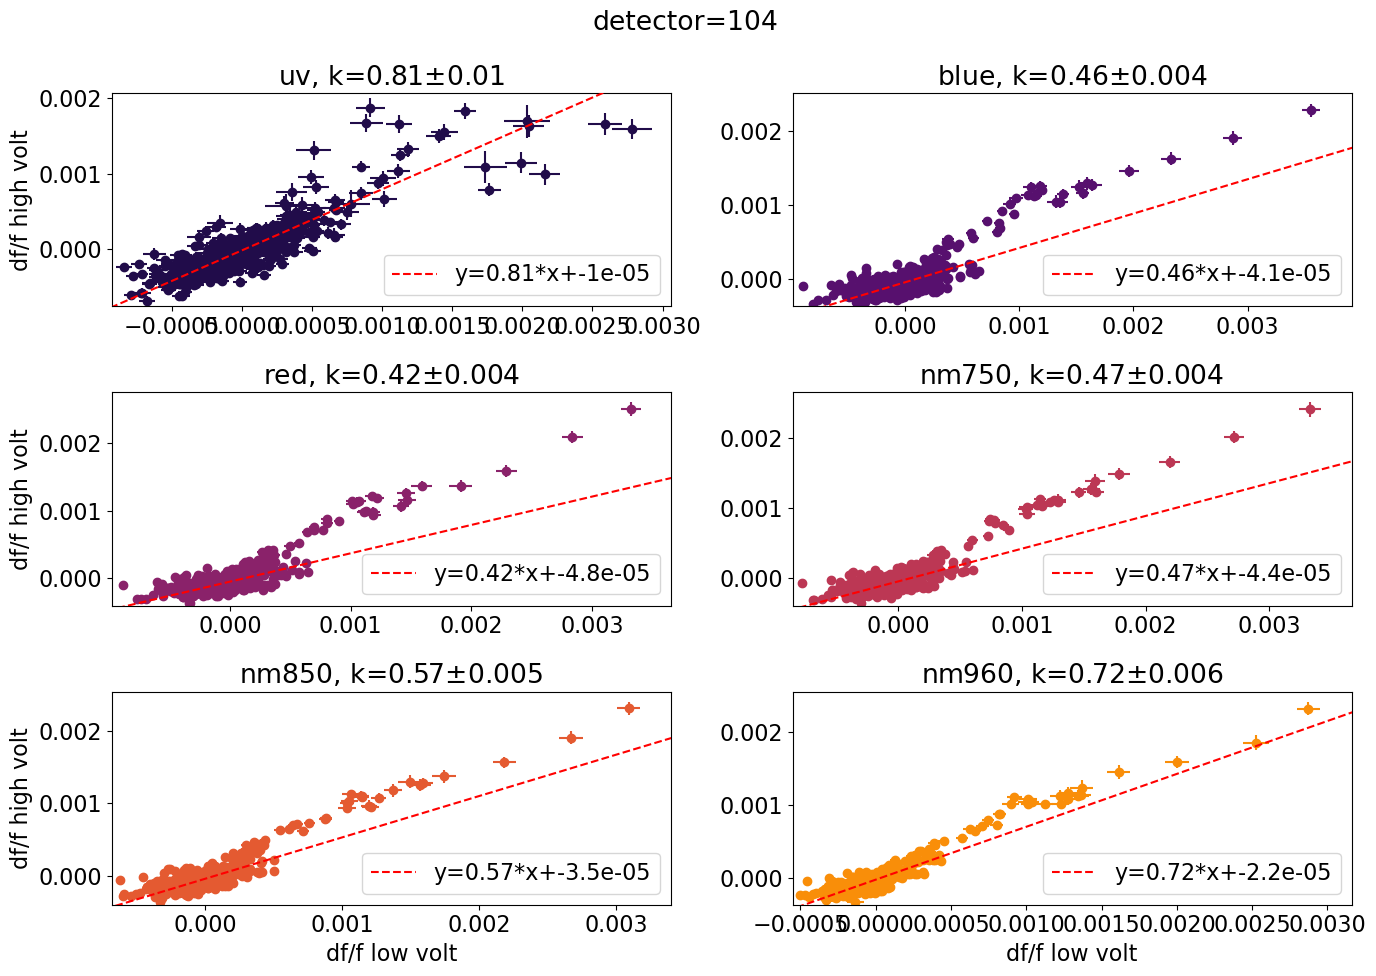

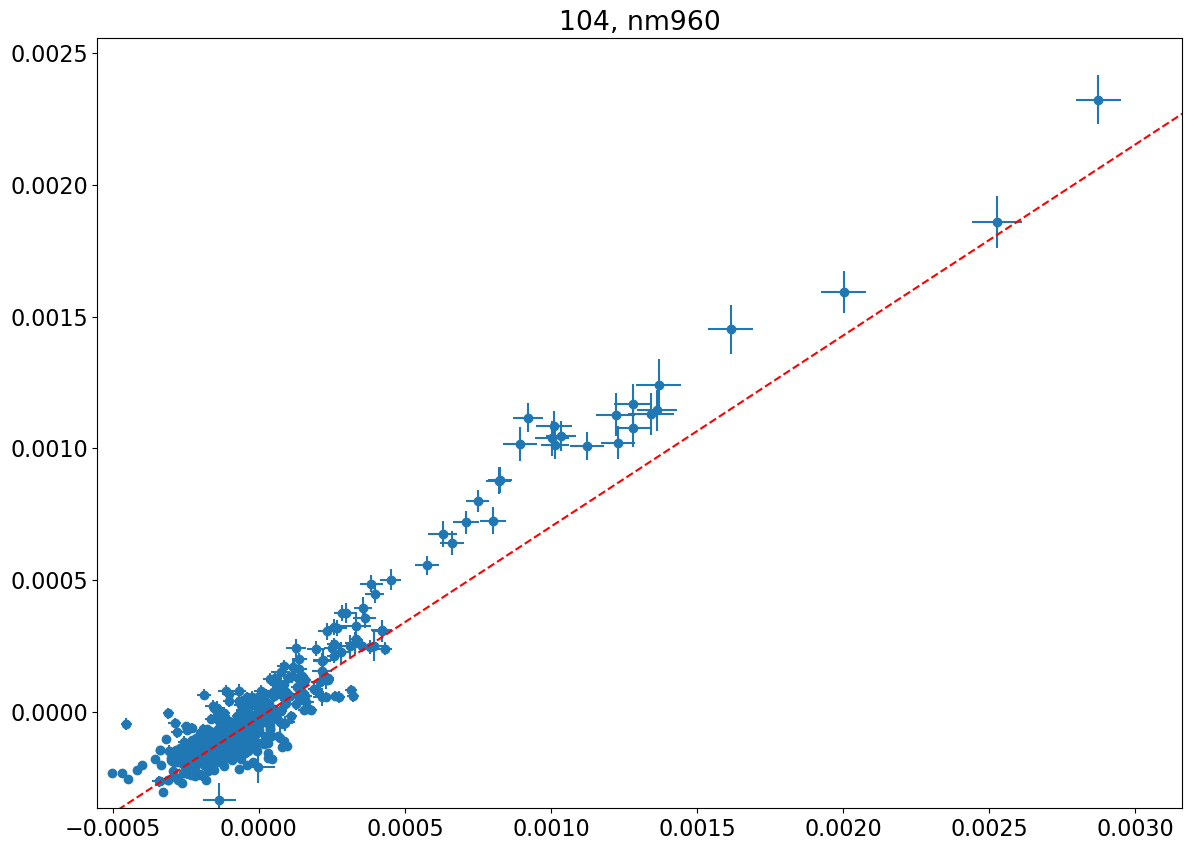

In [18]:
detector = 104
show_TR(detector)
show_fit(detector)
low_vs_high(detector, filts[5])

In [19]:
amp = {'itl':{filt:[] for filt in filts},'e2v':{filt:[] for filt in filts}}
for filt in filts: 
    for i in range(189):
        try: 
            center = xy_0[detectors[i].getName()]
            raft = detectors[i].getName()[:3]
            
            if center==[0,0]:
                continue
    
            if raft in e2v_R: 
                vendor = 'e2v'
            elif raft in itl_R: 
                vendor = 'itl'
            else: 
                continue
            
        
            rsignal_low, signal_low, signal_var_low = np.load(f'dats/TR_{i}_{filt}_low.npy')
            rsignal_high, signal_high, signal_var_high = np.load(f'dats/TR_{i}_{filt}_high.npy')
            signal_low_f = filter1d(signal_low)
            signal_high_f = filter1d(signal_high)
            
            rr, ind_low, ind_high = np.intersect1d(rsignal_low, rsignal_high, return_indices=True)
            signal_low, signal_var_low = signal_low[ind_low], signal_var_low[ind_low]
            signal_high, signal_var_high = signal_high[ind_high], signal_var_high[ind_high]
    
            amp_low = np.std(signal_low)
            amp_high = np.std(signal_high)
    
            amp[vendor][filt].append([amp_low,amp_high])
            
        except: 
            continue

Here are some more summary statistics of the tree-ring amplitudes, which we took as the mean square of the radial profile. In the following two plots, we show the distribution of high vs. low voltage tree-ring amplitudes via histograms and (25, 50, 75)-percentiles. 

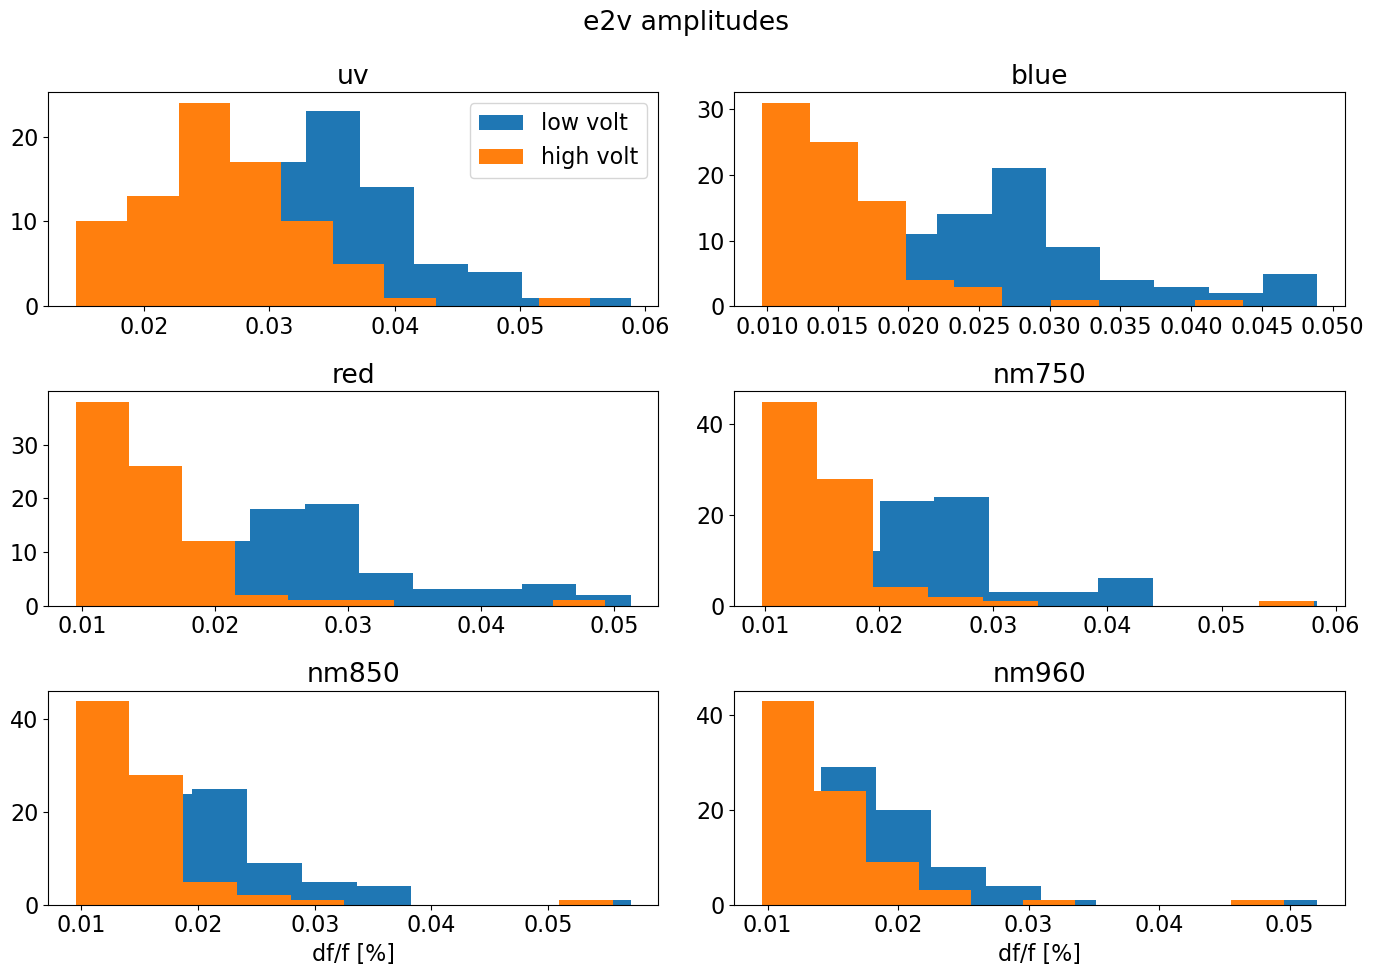

In [20]:
vendor = 'e2v'
nrow, ncol = 3,2
fig, axes = plt.subplots(nrow, ncol)#, sharex=True, sharey=True)

cmap = mplot.colormaps['inferno']
for i, filt in enumerate(filts):
    row, col = i//ncol, i%ncol
    color = cmap(1/8.+i/8.)
    ax = axes[row][col]

    amp_arr = np.array(amp[vendor][filt])
    amp_low = amp_arr[:,0]
    amp_high = amp_arr[:,1]

    ax.hist(amp_low*100, label='low volt')
    ax.hist(amp_high*100, label='high volt')
    ax.set_title(filt)

    if row == 2: 
        ax.set_xlabel('df/f [%]')

    if i==0: 
        ax.legend()
plt.suptitle(f'{vendor} amplitudes')
plt.tight_layout()
plt.show()

/tmp/ipykernel_7469/1065684635.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(a)


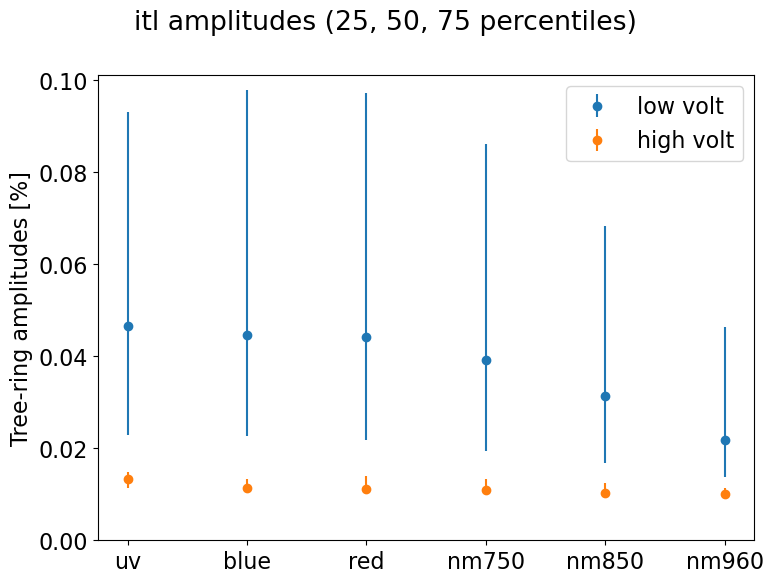

In [21]:
vendor = 'itl'
amp_low, amp_low_top, amp_low_bot = [], [], []
amp_high, amp_high_top, amp_high_bot = [], [], []
for i, filt in enumerate(filts):
    row, col = i//ncol, i%ncol
    color = cmap(1/8.+i/8.)
    ax = axes[row][col]

    amp_arr = np.array(amp[vendor][filt])*100
    
    amp_low.append(np.median(amp_arr[:,0]))
    amp_low_top.append(np.percentile(amp_arr[:,0],75) - np.median(amp_arr[:,0]))
    amp_low_bot.append(np.median(amp_arr[:,0]) - np.percentile(amp_arr[:,0],25))

    amp_high.append(np.median(amp_arr[:,1]))
    amp_high_top.append(np.percentile(amp_arr[:,1],75) - np.median(amp_arr[:,1]))
    amp_high_bot.append(np.median(amp_arr[:,1]) - np.percentile(amp_arr[:,1],25))

x = np.arange(6)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(x, amp_low, yerr=(amp_low_bot,amp_low_top),label='low volt',ls='none',marker='o')
ax.errorbar(x, amp_high, yerr=(amp_high_bot,amp_high_top),label='high volt',ls='none',marker='o')
fig.suptitle(f'{vendor} amplitudes (25, 50, 75 percentiles)')
plt.tight_layout()
ax.set_ylim(0,0.101)
ax.legend()
fig.canvas.draw()
a=ax.get_xticks().tolist()
for i in range(6):
    a[i+1] = filts[i] 
ax.set_xticklabels(a)
ax.set_ylabel('Tree-ring amplitudes [%]')
plt.tight_layout()

In [22]:
ratio = {'itl':{filt:[] for filt in filts},'e2v':{filt:[] for filt in filts}}
for filt in filts: 
    for i in range(189):
        try: 
            center = xy_0[detectors[i].getName()]
            raft = detectors[i].getName()[:3]
            
            if center==[0,0]:
                continue
    
            if raft in e2v_R: 
                vendor = 'e2v'
            elif raft in itl_R: 
                vendor = 'itl'
            else: 
                continue
            
        
            rsignal_low, signal_low, signal_var_low = np.load(f'dats/TR_{i}_{filt}_low.npy')
            rsignal_high, signal_high, signal_var_high = np.load(f'dats/TR_{i}_{filt}_high.npy')
            rsignal, ind_low, ind_high = np.intersect1d(rsignal_low, rsignal_high, return_indices=True)
            TR_low, err_high = signal_low[ind_low], np.sqrt(signal_var_low[ind_low])
            TR_high, err_low = signal_high[ind_high], np.sqrt(signal_var_high[ind_high])
    
            result = least_squares(residual, [1,0], args=(TR_low, TR_high, err_low, err_high))
            k, b = result['x']
            cov = np.linalg.inv(result['jac'].T.dot(result['jac']))
            k_err, b_err = np.sqrt(np.diag(cov))

            ratio[vendor][filt].append([k,k_err])
            
        except: 
            continue

Here we show the distribution of the ratio between high and low voltage tree-rings we fitted above

/tmp/ipykernel_7469/1403550903.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(a)


[Text(-1.0, 0, '-1.0'),
 Text(0.0, 0, 'uv'),
 Text(1.0, 0, 'blue'),
 Text(2.0, 0, 'red'),
 Text(3.0, 0, 'nm750'),
 Text(4.0, 0, 'nm850'),
 Text(5.0, 0, 'nm960'),
 Text(6.0, 0, '6.0')]

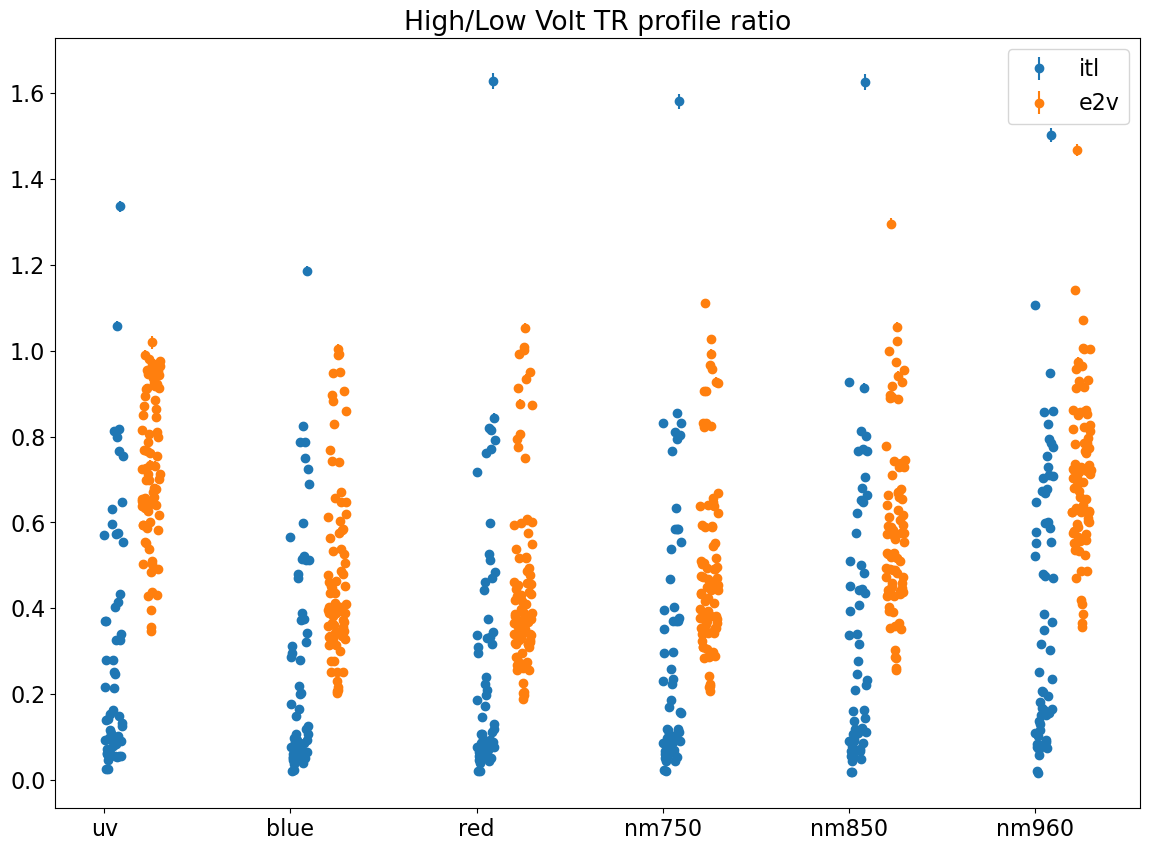

In [23]:
vendor = 'itl'

fig, ax = plt.subplots()
for i,filt in enumerate(filts): 
    ratio_dat = np.array(ratio['itl'][filt])
    x = np.linspace(i,i+0.1,len(ratio_dat))
    ax.errorbar(x,ratio_dat[:,0],yerr=ratio_dat[:,1],ls='none',marker='o',color='tab:blue',label='itl' if i==0 else None)

    ratio_dat = np.array(ratio['e2v'][filt])
    x = np.linspace(i+0.2,i+0.3,len(ratio_dat))
    ax.errorbar(x,ratio_dat[:,0],yerr=ratio_dat[:,1],ls='none',marker='o',color='tab:orange',label='e2v' if i==0 else None)
ax.legend()
ax.set_title('High/Low Volt TR profile ratio')
fig.canvas.draw()
a=ax.get_xticks().tolist()
for i in range(6):
    a[i+1] = filts[i] 
ax.set_xticklabels(a)

Here we show with an example that mean square root is (by eye) a good measure of the tree-ring amplitude.

0.0004166659776583565


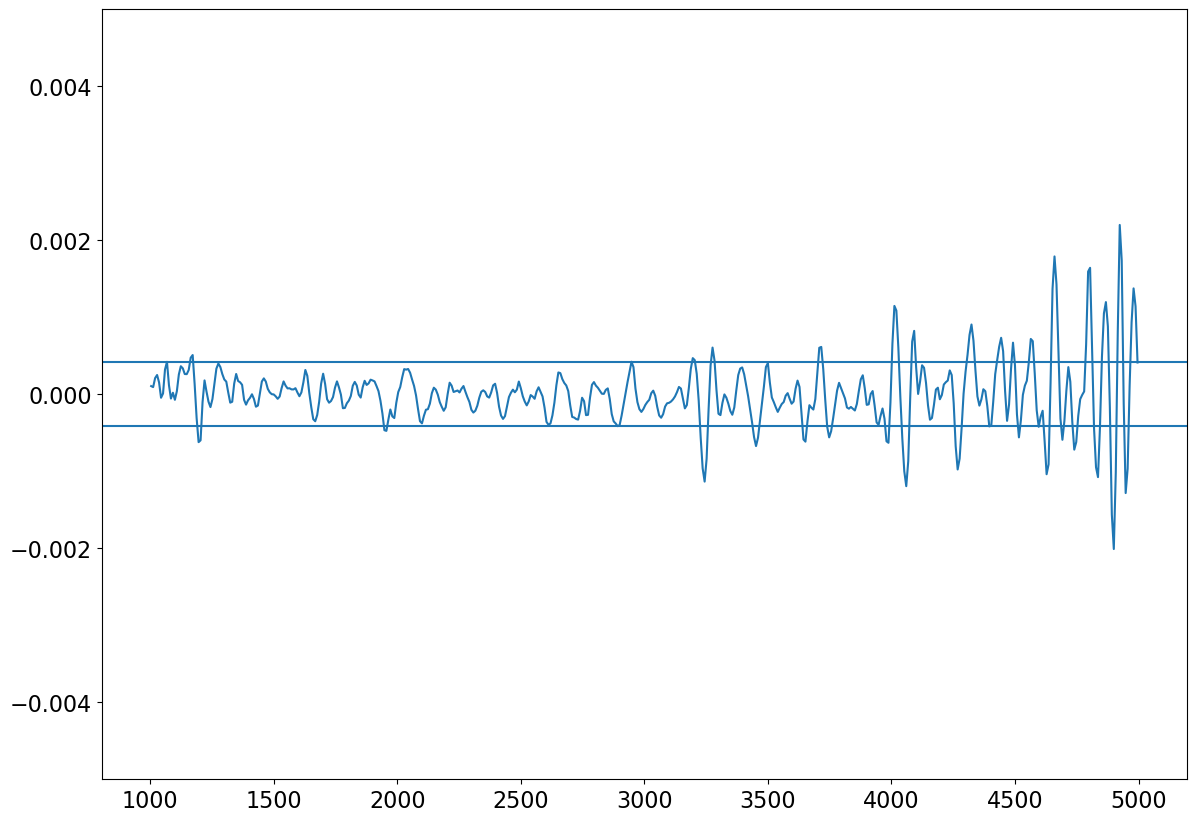

In [25]:
i=32
filt='nm850'
rsignal_low, signal_low, signal_var_low = np.load(f'dats/TR_{i}_{filt}_low.npy')
rsignal_high, signal_high, signal_var_high = np.load(f'dats/TR_{i}_{filt}_high.npy')
signal_low_f = filter1d(signal_low)
signal_high_f = filter1d(signal_high)

rr, ind_low, ind_high = np.intersect1d(rsignal_low, rsignal_high, return_indices=True)
signal_low, signal_var_low = signal_low[ind_low], signal_var_low[ind_low]
signal_high, signal_var_high = signal_high[ind_high], signal_var_high[ind_high]
plt.plot(rsignal_low, signal_low)
#plt.xlim(1000,5000)
plt.ylim(-5e-3,5e-3)
plt.axhline(np.std(signal_low))
plt.axhline(-np.std(signal_low))
print(np.std(signal_low))